# RF to B-Mode Generation

Ultrasound imaging employs acoustic pressure waves to gather information describing changes in tissue permeability. A transducer emits an ultrasound beam at discrete time intervals and translates the pressure wave echo into radio frequency waves. These electromagnetic waves are then readable with an analog-to-digital converter for machine input.

The following example notebook showcases how the ITK Ultrasound module may be used to generate a human-readable brightness-mode (B-Mode) image from RF-Mode input collected from a transducer. The input image `MouseLiverRF.mha` describes one ultrasound capture representing axial, lateral, and time dimensions. The `itk.b_mode_image_filter` function performs envelope detection on the RF signal along the axial direction and applies a logarithmic intensity transform to the image output for visibility.

In [1]:
# Install notebook dependencies
import sys
#!{sys.executable} -m pip install itk itk-ultrasound numpy matplotlib itkwidgets

In [2]:
import itk
from matplotlib import pyplot as plt
from itkwidgets import view, compare

## Read RF Image

The example RF image represents raw transducer output describing a mouse liver sample. Taken alone, the RF sample fails to deliver good insight into the mouse liver image. We must perform envelope detection and brightness filtering on the image in order to generate a BMode image for analysis.

In [3]:
SAMPLING_FREQUENCY = 40e6 # Hz
SAMPLING_PERIOD = SAMPLING_FREQUENCY ** -1

# Image dimensions: [axial, lateral, frame]
rf_image = itk.imread('Input/MouseLiverRF.mha', itk.F)
print(itk.size(rf_image))
view(rf_image)

itkSize3 ([1536, 128, 4])


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

The RF image represents transducer results over a certain time period with regards to the axial direction (along the beam) and the lateral direction (normal to the beam). Data along the axial direction describes how the ultrasound wave echo propagated through the image medium. Here we use `matplotlib` to visualize the waveform at a fixed lateral position at T=0.

In [4]:
def visualize_beam_waveform(image, lateral_idx=0, time_idx=0):
    arr = itk.array_view_from_image(image)
    x_labels = [idx * SAMPLING_PERIOD for idx in range(0,arr.shape[2])]
    plt.plot(x_labels,arr[time_idx,lateral_idx,:])
    plt.xlabel('Sampling Time ($\mu$s)')
    plt.ylabel('Response')
    plt.show()

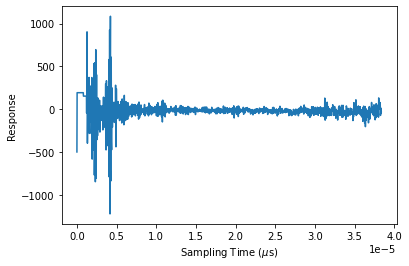

In [5]:
# Visualize one RF waveform
visualize_beam_waveform(rf_image)

## Perform Envelope Detection

To understand how the pressure wave echo travelled through the imaging medium we apply amplitude demodulation through envelope detection. 

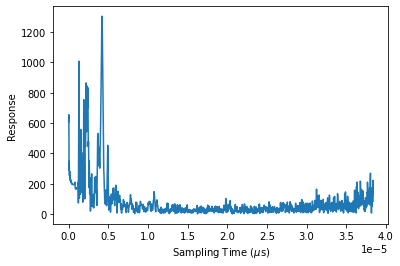

In [6]:
# Note that dimension in direction of analytic signal filter must be
# a multiple of 2,3,5 for the FFT to be valid
padded_image = itk.fft_pad_image_filter(rf_image)
complex_image = itk.analytic_signal_image_filter(rf_image,direction=0)
modulus_image = itk.complex_to_modulus_image_filter(complex_image)

visualize_beam_waveform(modulus_image)

In [7]:
view(modulus_image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

## Apply Logarithmic Transform

To get data on a more useful scale for analysis we apply a log10 transform over the intensity image. Other transforms such as smoothing and clamping may also be applied to help translate the intensity image into a human-interpretable format.

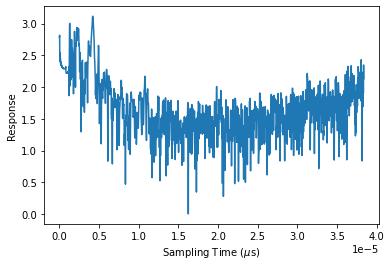

In [8]:
log_image = itk.log10_image_filter(modulus_image)

visualize_beam_waveform(log_image)

In [9]:
view(log_image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

## Use `BModeImageFilter` for RF-to-BMode image generation

`itk.BModeImageFilter` combines envelope detection and logarithmic transformation to produce a straightforward pipeline for BMode image generation. Note that `MouseLiverB.mha` is produced using a similar method but with additional transformations for visibility and is intended only for general comparison here.

In [10]:
bmode_image = itk.imread('Input/MouseLiverB.mha', itk.F)

In [11]:
filtered_image = itk.b_mode_image_filter(rf_image,direction=1)
compare(filtered_image, bmode_image)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

## Beamline Over Time

We can plot pixel values along the axial direction over time to investigate how the BMode filter transforms data.

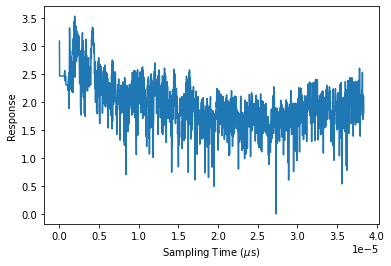

In [12]:
# BMode Image (calculated)
visualize_beam_waveform(filtered_image)

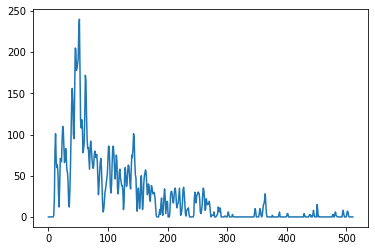

In [13]:
# BMode Image (expected)
arr = itk.array_view_from_image(bmode_image)
plt.plot(arr[0,:,0])
plt.show()